In [1]:
%pip install google-genai
%pip install matplotlib
%pip install os
%pip install dotenv
%pip install pydantic


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement os (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
ERROR: No matching distribution found for os
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updat

In [2]:
from google import genai
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from dotenv import load_dotenv
from google.genai import types
from pydantic import BaseModel, Field
from io import BytesIO
from PIL import Image

In [3]:
class GendersVerification(BaseModel):
    result: bool = Field(description="Whether the genders are opposite.")
    stop_reason: str | None = Field(None, description="The stop reason when result is False.")

In [4]:
def create_genai_client():
    import os

    api_key = os.getenv("GOOGLE_API_KEY")
    if not api_key:
        raise ValueError("GOOGLE_API_KEY not found in .env file")    

    # Configure the client with your API key
    client = genai.Client(api_key=api_key, http_options={'api_version': 'v1alpha'})

    return client

In [5]:
def load_image(image_path: str):
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: The file at '{image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [6]:
def get_inline_data_part(image_path: str):
    import mimetypes

    try:
        mime_type, _ = mimetypes.guess_type(image_path)
        if mime_type is None:
            mime_type = 'application/octet-stream'
            print(f"Warning: Could not determine MIME type for {image_path}. Defaulting to {mime_type}.")

        file_bytes: bytes | None = None
        with open(image_path, "rb") as image_file:
            file_bytes = image_file.read()
        
        if file_bytes is None:
            raise Exception(f"Unable to read the bytes from {image_path}")
    
        return types.Part(
            inline_data=types.Blob(
                mime_type=mime_type,
                data=file_bytes
            ),
            media_resolution={"level": "media_resolution_high"}
        ) 
    except FileNotFoundError:
        print (f"Error: The file was not found at {image_path}")
    except Exception as e:
        print (f"An error occurred: {e}")

In [7]:
def print_token_usage(response: types.GenerateContentResponse):
    if response and response.usage_metadata:
        usage_metadata = response.usage_metadata
        input_token_count = usage_metadata.prompt_token_count
        output_token_count = usage_metadata.candidates_token_count
        total_token_count = usage_metadata.total_token_count
        thought_token_count = usage_metadata.thoughts_token_count
        cached_token_count = usage_metadata.cached_content_token_count
        print(f"Input: {input_token_count}, Output: {output_token_count}, Thought: {thought_token_count}, Cached: {cached_token_count} Total: {total_token_count}")

In [8]:
tools = [types.Tool(google_search=types.GoogleSearch())]

def verify_genders(person_a_image: str, person_b_image: str):
    gender_verification_prompt = """
    Role: You are an Advanced Image Content Validator. Your goal is to identify human subjects for a biological analysis tool, even in complex images.

    Task: Analyze two input images (Image A and Image B). Locate the primary human subject in each image and verify their genders.

    Validation & Selection Logic:

    1. Smart Subject Detection:
    - Scan each image for a human face or figure.
    - Crucial: If an image contains both humans and objects (e.g., a person holding a guitar, a person next to a car, or a person in a cluttered room), you must ignore the objects and focus exclusively on the human.
    - If multiple humans are present, select the most prominent/clearest face as the subject for that image.
    - Failure Condition: If no recognizable human face is found in one or both images (e.g., only a landscape, animal, or object is visible), set "result" to false and "stop_reason" to "One or both images do not contain a detectable human face."

    2. Gender Verification:
    - Analyze the biological sex or gender presentation of the selected human subject in Image A and Image B.
    - Failure Condition: If the subjects are of the same gender (Male+Male or Female+Female), set "result" to false and "stop_reason" to "Please upload one male and one female."

    3. Pass Condition:
    - If both images contain a human subject AND they are of opposite genders (One Male + One Female), set "result" to true and "stop_reason" to null.

    Output Schema:
    Return ONLY a single JSON object with no markdown formatting or additional text.

    {
    "result": boolean,
    "stop_reason": string | null
    }
    """
    response = client.models.generate_content(
        model="gemini-3-pro-preview",
        contents=[
            types.Content(
                parts=[
                    types.Part(text=gender_verification_prompt),
                    get_inline_data_part(person_a_image),
                    get_inline_data_part(person_b_image),
                ]
            )
        ],
        config=types.GenerateContentConfig(
            response_mime_type="application/json",
            response_json_schema=GendersVerification.model_json_schema(),
            tools=tools
        )
    )

    print_token_usage(response)
    result = GendersVerification.model_validate_json(response.text)
    return result

In [ ]:
def generate_sibling_images(person_a_image: str, person_b_image: str):
    prompt = """
    A group portrait of four distinct young adult siblings (two males, two females, aged 18-22). 
    They are the biological offspring of the provided references, generated with **high genetic variability**. 
    The faces must display a **randomized distribution of traits**, where features (eyes, nose, mouth, jawline) are mixed **unequally** across the four subjects. 
    Ensure distinctiveness: Sibling 1 should lean strongly towards the father's features, Sibling 2 towards the mother's, while Siblings 3 and 4 represent complex, unique mixes of recessive and dominant traits. 
    **Crucial:** All four must have fresh, smooth, youthful skin and collegiate appearances. 
    Do not transfer the parents' wrinkles or skin texture. 2k resolution, photorealistic, detailed distinct faces.
    """

    response = client.models.generate_content(
        model="gemini-3-pro-image-preview",
        contents=[
            types.Content(
                parts=[
                    types.Part(text=prompt),
                    get_inline_data_part(person_a_image),
                    get_inline_data_part(person_b_image),
                ]
            )
        ],
        config=types.GenerateContentConfig(
            response_modalities=['TEXT', 'IMAGE'],
            image_config=types.ImageConfig(
                image_size="2K",  
            ),
            tools=tools,
            thinking_config=types.ThinkingConfig(
                include_thoughts=False
            ),
            temperature=0.5
        )
    )

    print_token_usage(response)
    if response.candidates and response.candidates[0].content and response.candidates[0].content.parts:
        for part in response.candidates[0].content.parts:
            if part.thought and part.text:
                print("Thought Summary: ", part.text)
            elif part.text:
                print("Text: ", part.text)
            if part.inline_data:
                image_bytes = part.inline_data.data
       
    return image_bytes

In [11]:
def print_result(person_a_image: str, person_b_image: str):
    load_image(person_a_image)
    load_image(person_b_image)

    result = verify_genders(person_a_image=person_a_image, person_b_image=person_b_image)
    if result.result:
        offspring_bytes = generate_sibling_images(person_a_image, person_b_image)
        offspring_image = Image.open(BytesIO(offspring_bytes)) if offspring_bytes else None
        if offspring_image:
            plt.imshow(offspring_image)
            plt.axis('off')
            plt.show()
        pass
    else:
        if result.stop_reason:
            print ("Stop reason:", result.stop_reason)

def print_test_cases(heading: str, cases: list[list[str]]):
    print(heading)
    for case in cases:
        print_result(person_a_image=case[0], person_b_image=case[1])

In [12]:
load_dotenv()

# Configure the client with your API key
client = create_genai_client()

In [ ]:
same_gender_cases = [
    ['./couples/prince_william.jpg', './couples/david_beckham.webp']
]

print_test_cases(heading="Same gender cases (Expected failure)", cases=same_gender_cases)

In [ ]:
print_test_cases(heading="Couple cases", cases=[
    ['./couples/prince_william.jpg', './couples/princess_kate.jpg'],
])

Couple cases


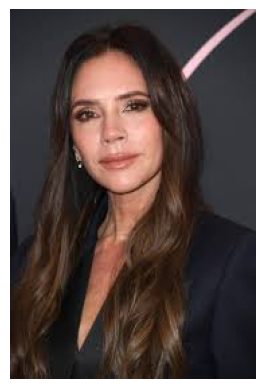

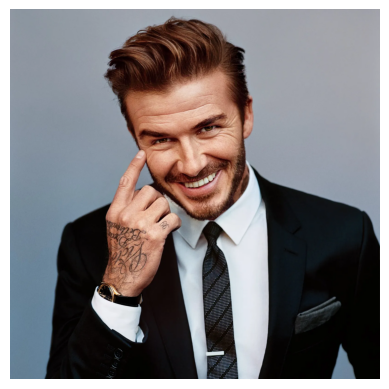

Input: 2583, Output: 17, Thought: 171, Cached: None Total: 2771
Input: None, Output: 1444, Thought: 515, Cached: None Total: 2048
Thought Summary:  **Developing Character Designs**

I'm currently fleshing out the appearance of the four siblings. I'm focusing on blending the prominent features of their parents in a believable, randomized way for each sibling. Clothing and setting details are also being finalized to support their individual identities and the overall aesthetic. The goal is to create a realistic group portrait showcasing a youthful, cohesive unit.



Thought Summary:  **Evaluating Photo Fidelity**

I've confirmed the image's faithfulness to the prompt. It accurately represents the requested family portrait with the specified individuals, showcasing the desired genetic variance and collegiate appearance. The image does what it needed to do.





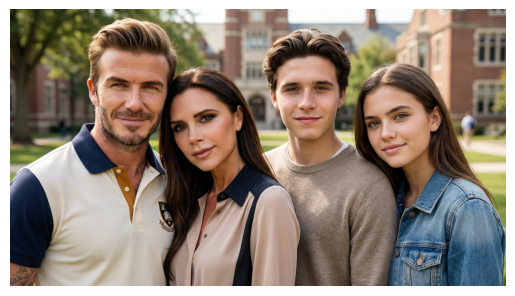

In [14]:
print_test_cases(heading="Couple cases", cases=[
    ['./couples/victoria_beckham.jpg', './couples/david_beckham.webp']
])

In [ ]:
print_test_cases(heading="Couple cases", cases=[
    ['./couples/Shizuka_Kudo.jpg', './couples/Takuya_Kimura.jpg'],
])